In [38]:
from sklearn.model_selection import train_test_split
from sklearn import datasets, svm
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.metrics import confusion_matrix
from sklearn.cluster import AgglomerativeClustering
import numpy as np
from math import sqrt
from shapleycomposition import ShapleyExplainer
from composition_stats import ilr, sbp_basis
from bifurc_tree import create_tree_from_sbp, init_graph, build_graph, sbp_from_aggloclustchildren
import plotly.graph_objects as go
from mahalanobis_matrix import mahalanobis_matrix
import matplotlib.pyplot as plt

In [2]:
import os

out_dir = os.path.join('figures', 'moreclasses')
os.makedirs(out_dir, exist_ok=True)

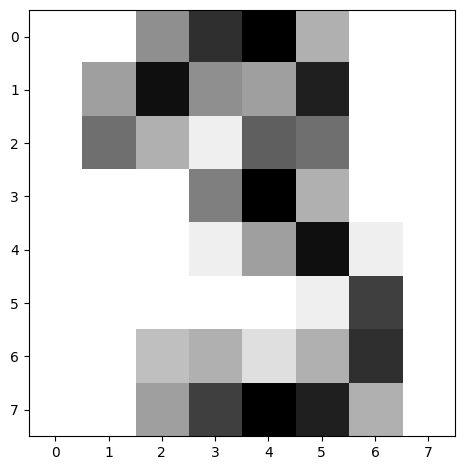

In [306]:
N_class = 10   #Number of class, the dimension of the simplex is therefore N_class-1

#load the dataset, take a subset of N_class classes, scale it and split into a training and testing set
X, Y = datasets.load_digits(return_X_y=True)
subset_i = np.where(Y < N_class)
X = X[subset_i]
Y = Y[subset_i]
#X = scale(X)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)


K = np.argwhere(Y_test==3)[4][0]         #Index of the instance you want to test in the test set

fig, ax = plt.subplots(nrows=1, ncols=1)
ax.imshow(X_test[K].reshape([8,8]), cmap='binary')
fig.tight_layout()

In [247]:
#train an SVM classifier
svc_linear = svm.SVC(kernel='rbf', probability=True)
svc_linear.fit(X_train, Y_train)

SVC(probability=True)

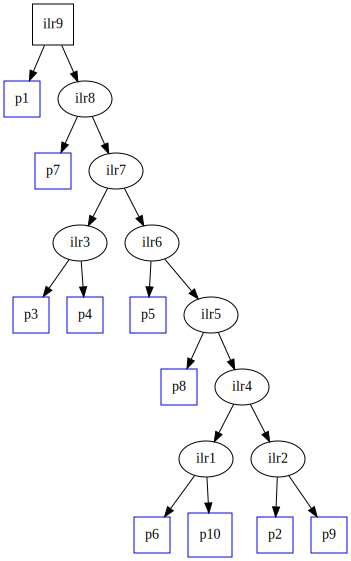

In [248]:
#Choose a sequential binary partition matrix and plot the corresponding bifurcation tree
# sbpmatrix = np.array([[1,1,-1,-1,1,1,1],[1,-1,0,0,-1,-1,-1],[0,1,0,0,-1,-1,-1],[0,0,0,0,1,-1,-1],[0,0,0,0,0,1,-1],[0,0,1,-1,0,0,0]])
#sbpmatrix = np.array([[1,-1,1,-1,1,-1,1],[1,0,1,0,-1,0,-1],[0,0,0,0,1,0,-1],[1,0,-1,0,1,0,0],[0,1,0,1,0,-1,0],[0,1,0,-1,0,0,0]])

#Get a sequential binary parition from the agglomeration of classes from a distance matrix between classes. Distance matrix is here made of the mahalanobis distance between a pair of classes in the ILR space output by the classifier (assuming normal distribution with same covariance matrix between a pair of classes).
M = mahalanobis_matrix(svc_linear.predict_proba, X_test, Y_test)
sbpmatrix = sbp_from_aggloclustchildren(AgglomerativeClustering(metric='precomputed', linkage='average').fit(M).children_)

#basis = np.flip(sbp_basis(sbpmatrix), axis=0)
basis = sbp_basis(sbpmatrix)
root = create_tree_from_sbp(sbpmatrix, N_class)

##Visualise the tree using graphviz
graph = init_graph()
build_graph(root, graph)
#graph.render('tree.pdf', view=True)
graph       #plot the bifurcation tree


In [307]:
# Explain all the predictions in the test set
explainer = ShapleyExplainer(svc_linear.predict_proba, X_train, N_class, sbpmatrix=sbpmatrix,
                            names_classes=[str(i) for i in range(N_class)], m_max=20000)
(shapley, base) = explainer.explain_instance(np.array(X_test[K]))

print("True label of the tested instance: ", end="")
print(Y_test[K])

#get the model prediction for the Kth instance of the test partition
pred = svc_linear.predict_proba(X_test[K].reshape(1,-1))
print("Prediction on the simplex: ",end="")
print(pred)
ilr_pred = ilr(pred, basis=basis)
print("Prediction in the ILR space: ",end="")
print(ilr_pred)

#The sum of the base distribution and the shapley composition in the ILR space is equal to the predicted probability distribution
sum_shap_base = np.array(shapley).sum(axis=0)+base
print("Sum of the shapley composition and the base distribution in the ILR space: ", end="")
print(sum_shap_base)

True label of the tested instance: 3
Prediction on the simplex: [[9.57758422e-04 3.99876568e-04 3.97295227e-03 9.69413959e-01
  6.24383773e-04 2.85764522e-03 7.66516998e-04 1.04963825e-03
  9.45941363e-04 1.90113285e-02]]
Prediction in the ILR space: [-1.33999358 -0.60883638 -3.88709485  2.48360351 -0.63260075 -0.99069407
  4.52508307 -1.53014405 -1.15729396]
Sum of the shapley composition and the base distribution in the ILR space: [-1.33999359 -0.60883639 -3.88709485  2.48360351 -0.63260074 -0.99069407
  4.52508307 -1.53014405 -1.15729396]


In [308]:
#SUMMARIZE WITH NORM, COSINE AND INNER PRODUCTS

(norm_shapley, proj_shap_class, cos_shap_shap) = explainer.summarize()

List of the features sorted by their Shapley strength (norm of their Shapley composition):
	 feature n.27: 1.3034871
	 feature n.44: 1.1225429
	 feature n.43: 0.8157411
	 feature n.46: 0.7499616
	 feature n.53: 0.708192
	 feature n.29: 0.6970724
	 feature n.36: 0.6826412
	 feature n.35: 0.6649191
	 feature n.62: 0.6442263
	 feature n.38: 0.6225955
	 feature n.55: 0.6026507
	 feature n.20: 0.5995272
	 feature n.45: 0.5843222
	 feature n.47: 0.5357383
	 feature n.19: 0.5166499
	 feature n.37: 0.4925233
	 feature n.14: 0.4128107
	 feature n.52: 0.4079306
	 feature n.21: 0.3778525
	 feature n.11: 0.3632685
	 feature n.54: 0.3474143
	 feature n.30: 0.3439593
	 feature n.5: 0.3201657
	 feature n.61: 0.2933678
	 feature n.13: 0.2881589
	 feature n.22: 0.2683641
	 feature n.63: 0.236725
	 feature n.12: 0.2228864
	 feature n.18: 0.1999296
	 feature n.51: 0.1586966
	 feature n.28: 0.1484006
	 feature n.31: 0.1482438
	 feature n.10: 0.1391172
	 feature n.34: 0.1349897
	 feature n.26: 0.1307964
	 

/home/pnoe/Documents/shapley/shapley_composition/shapleycomposition.py:160: RuntimeWarning: invalid value encountered in scalar divide
  cos_shap_shap[i,j] = np.dot(self.shapley[i,:],self.shapley[j,:])/(norm_shapley[i]*norm_shapley[j])


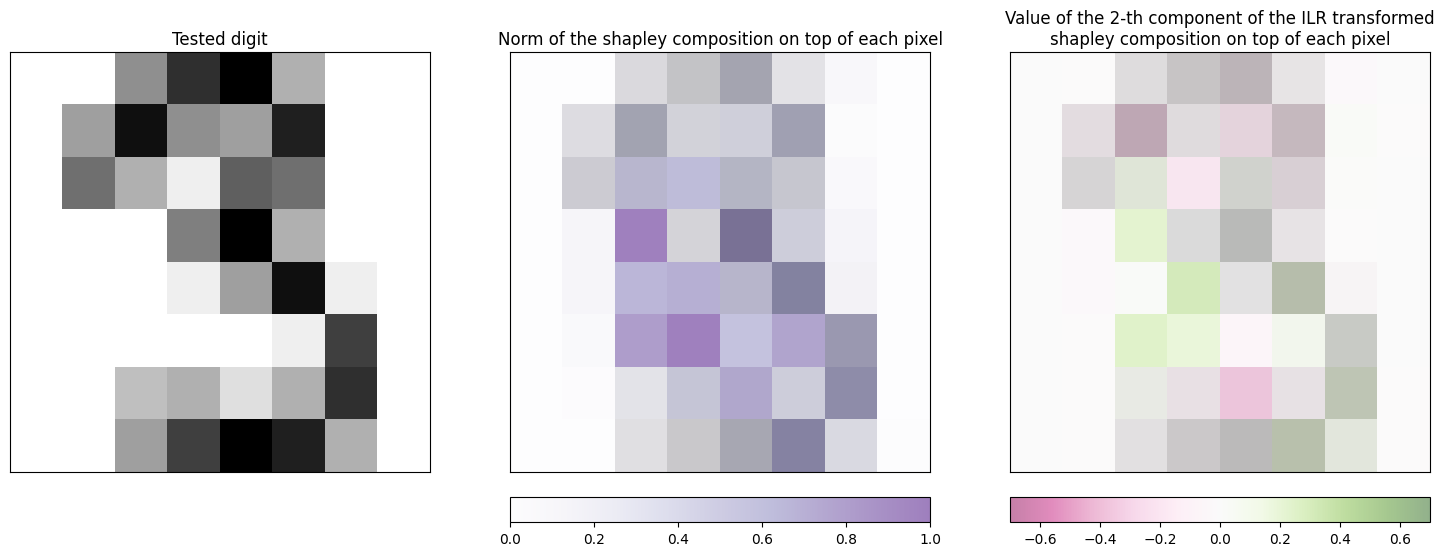

In [310]:

#PLOT ON TOP OF EACH PIXEL
fig = plt.figure(figsize=(10,10))


ax = []
for i in range(3):
    ax.append(fig.add_axes([i/2, 0, 0.42, 0.42]))
    ax[-1].axes.get_xaxis().set_ticks([])
    ax[-1].axes.get_yaxis().set_ticks([])

#Plot the digit
ax[0].imshow(X_test[K].reshape([8,8]), cmap='binary')
ax[0].title.set_text('Tested digit')

#Plot the norm of the shapley composition on top of each pixels.
ax[1].imshow(X_test[K].reshape([8,8]), cmap='binary', alpha=0.5)
ax[1].title.set_text('Norm of the shapley composition on top of each pixel')
im = ax[1].imshow(norm_shapley.reshape([8,8]), cmap='Purples', alpha=0.5)
im.set_clim(0, 1)
cax = fig.add_axes([0.5, -0.05, 0.42, 0.025])
fig.colorbar(im, cax=cax, orientation='horizontal')


#Plot the value of the i-th component of the ILR transformed shapley composition on top of each pixel. 
#Check the bifurcation tree to understand the meaning of such component.
i=2
ax[2].imshow(X_test[K].reshape([8,8]), cmap='binary', alpha=0.5)
ax[2].title.set_text('Value of the '+str(i)+'-th component of the ILR transformed\nshapley composition on top of each pixel')
im = ax[2].imshow(shapley[:,i-1].reshape([8,8]), cmap='PiYG', alpha=0.5)
im.set_clim(-0.7, 0.7)
cax = fig.add_axes([1.0, -0.05, 0.42, 0.025])
fig.colorbar(im, cax=cax, orientation='horizontal')



